In [1]:
%load_ext autoreload
%autoreload 2
import warnings
import numpy as np
import time
import os
from dotenv import load_dotenv
os.environ["USE_PYGEOS"] = "0"
import napari_sparrow as nas
from spatialdata import read_zarr
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import sample 
import scanpy as sc
import seaborn as sns
import anndata as ad
%run own_and_modified_functions.ipynb
warnings.simplefilter(action='ignore')

the value of the environment variable BASIC_DCT_BACKEND is not in ["JAX","SCIPY"]


In [2]:
OUTPUT_DIR = '/home/wout/Documents/Thesis_lokaal/Mouse_Liver_Resolve_Data/'
anndata_objects = []
name_anndata = "A1-1"+"/"+"anndataNucA11"
anndata = sc.read(OUTPUT_DIR + '/' + name_anndata + '_all_0threshold_shape_distances')
anndata_objects.append(anndata)
name_anndata = "A1-2"+"/"+"anndataNucA12"
anndata = sc.read(OUTPUT_DIR + '/' + name_anndata + '_all_0threshold_shape_distances')
anndata_objects.append(anndata)
name_anndata = "C2"+"/"+"anndataNucC2"
anndata = sc.read(OUTPUT_DIR + '/' + name_anndata + '_all_0threshold_shape_distances')
anndata_objects.append(anndata)
name_anndata = "D2-1"+"/"+"anndataNucD21"
anndata = sc.read(OUTPUT_DIR + '/' + name_anndata + '_all_0threshold_shape_distances')
anndata_objects.append(anndata)
name_anndata = "PS"+"/"+"ps_slice"
anndata = sc.read(OUTPUT_DIR + '/' + name_anndata + '_all_0threshold_shape_distances')
anndata_objects.append(anndata)
samples = ["A1-1", "A1-2", "C2", "D2-1", "PS"]

In [3]:
for anndata in anndata_objects:
    print(anndata.shape)

(11283, 99)
(8695, 95)
(27133, 100)
(12519, 99)
(11794, 96)


In [4]:
# Give Leiden clusters unique numbers over all samples
nr_leiden_clusters = []
for i in range(len(anndata_objects)):
    nr_leiden_clusters.append(len(np.unique(anndata_objects[i].obs['leiden'])))
    anndata_objects[i].obs['leiden'] = anndata_objects[i].obs['leiden'].astype(int) + sum(nr_leiden_clusters[:i])
    anndata_objects[i].obs['leiden'] = anndata_objects[i].obs['leiden'].astype(str)
    anndata_objects[i].obs['leiden'] = anndata_objects[i].obs['leiden'].astype('category')

In [5]:
anndata_samples_together = anndata_objects[0].concatenate(anndata_objects[1],anndata_objects[2],anndata_objects[3],anndata_objects[4])

In [19]:
columns = ['% >0','mean of >0','variance of >0']
rows=anndata_samples_together.var_names
columns=columns
df = pd.DataFrame(index=rows, columns=columns)
for i in range(len(anndata_samples_together.var_names)):
    a = anndata_samples_together.layers['raw_counts'][:,i]
    a = a[a>0]
    df.iloc[i] = [round(100*len(a)/len(anndata_samples_together.obs_names),2),int(np.mean(a)),np.round(a.var(),1)]
df = df.sort_values(by=['mean of >0'],ascending=False)

In [20]:
data = df['mean of >0']
Q1 = np.percentile(data, 25, interpolation = 'midpoint') 
Q2 = np.percentile(data, 50, interpolation = 'midpoint') 
Q3 = np.percentile(data, 75, interpolation = 'midpoint') 
IQR = Q3 - Q1
outliers = []
for i in data:
    if i > Q3 + 1.5 * IQR or i < Q1 - 1.5 * IQR:
        outliers.append(i)
print(outliers)
df.head(len(outliers))

[69, 41, 34, 18, 11, 10, 9]


,% >0,mean of >0,variance of >0
Cyp2e1,59.31,69,5282.8
Pck1,88.68,41,2170.6
Spp1,3.93,34,1602.9
Fn1,90.95,18,308.6
Clec4f,23.12,11,207.4
Cd5l,26.21,10,180.4
Stab2,22.86,9,92.6


Text(0, 0.5, 'Number of genes')

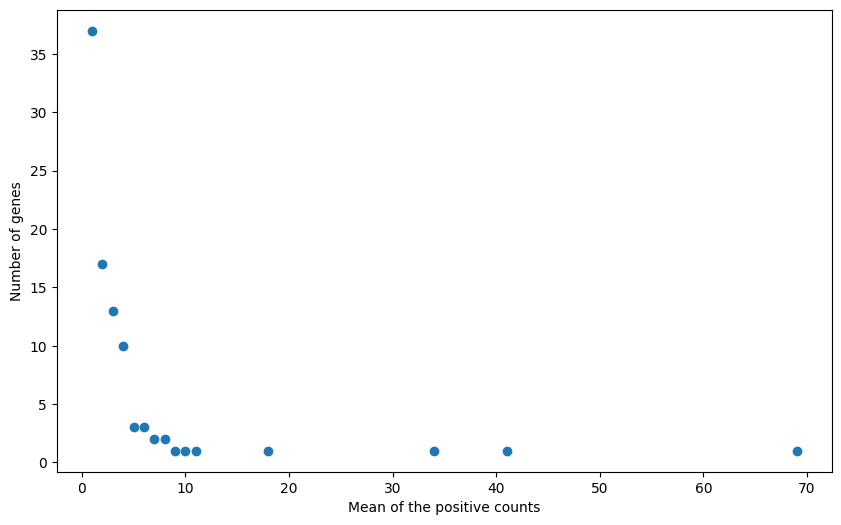

In [21]:
# new plot
plt.figure(figsize=(10,6))
a = df['mean of >0'].value_counts()
a = a.sort_index()
# make scatter plot
plt.scatter(a.index,a.values)
plt.xlabel("Mean of the positive counts")
plt.ylabel("Number of genes")

In [22]:
# Genes that are Hepa markers in some/all of the marker gene lists
Hepa_markers = ['Cxcl12','Prox1','Pck1','Ghr','Fn1','Slc40a1','Cyp2e1','Sds','Gls2','Glul','Hal','Lgr5']
df_hepa = df.loc[Hepa_markers]
df_hepa = df_hepa.sort_values(by=['% >0'],ascending=False)
df_hepa

,% >0,mean of >0,variance of >0
Fn1,90.95,18,308.6
Pck1,88.68,41,2170.6
Ghr,81.92,5,27.8
Cyp2e1,59.31,69,5282.8
Prox1,58.87,3,6.4
Hal,51.03,5,24.8
Slc40a1,46.92,2,7.6
Sds,41.52,7,52.9
Gls2,38.3,2,2.1
Glul,33.58,6,146.2


In [29]:
columns = ['mean_counts']
rows=anndata_samples_together.var_names
columns=columns
df_binned = pd.DataFrame(index=rows, columns=columns)
for i in range(len(anndata_samples_together.var_names)):
    a = anndata_samples_together.layers['raw_counts'][:,i]
    df_binned.iloc[i] = [np.round(np.mean(a),2)]
df_binned = df_binned.sort_values(by=['mean_counts'],ascending=False)
df_binned.head(15)

,mean_counts
Cyp2e1,40.99
Pck1,36.51
Fn1,17.04
Ghr,4.72
Sds,3.05
Clec4f,2.66
Cd5l,2.63
Hal,2.58
Stab2,2.21
Glul,2.14


In [ ]:
annotation = 'annotation_own_score_genes_BasicMartin_12'

In [ ]:
sns.boxplot(y=annotation,x='area',data=anndata_samples_together.obs,whis=(5,90),showfliers=False)
plt.show()
sns.boxplot(y=annotation,x='eccentricity',data=anndata_samples_together.obs,whis=(5,90),showfliers=False)
plt.show()
sns.boxplot(y=annotation,x='extent',data=anndata_samples_together.obs,whis=(5,90),showfliers=False)
plt.show()
sns.boxplot(y=annotation,x='solidity',data=anndata_samples_together.obs,whis=(5,90),showfliers=False)
plt.show()
sns.boxplot(y=annotation,x='intensity_mean',data=anndata_samples_together.obs,whis=(5,90),showfliers=False)
plt.show()
sns.boxplot(y=annotation,x='distance_to_edge',data=anndata_samples_together.obs,whis=(5,90),showfliers=False)
plt.show()
sns.boxplot(y=annotation,x='distance_to_vein',data=anndata_samples_together.obs,whis=(5,90),showfliers=False)
plt.show()

In [ ]:
def compare_features_of_ct_between_annotations(anndata,annotations,annotations_names,celltype,plot=True):
    df = pd.DataFrame(columns=['annotation', 'area', 'eccentricity', 'extent', 'solidity', 'intensity_mean', 'distance_to_edge', 'distance_to_vein'])
    for annotation in annotations:
        df_add = anndata.obs[anndata.obs[annotation] == celltype]
        df_add = df_add.drop(columns=[col for col in df_add.columns if col not in ['area', 'eccentricity', 'extent', 'solidity', 'intensity_mean', 'distance_to_edge', 'distance_to_vein']])
        df_add['annotation'] = annotations_names[annotations.index(annotation)]
        df = pd.concat([df, df_add])
    df['annotation'] = df['annotation'].astype('category')
    df = df.reset_index(drop=True)
    if plot:
        for column in df.columns:
            if column != 'annotation':
                sns.boxplot(y='annotation',x=column,data=df,whis=(5,90),showfliers=False)
                plt.title(celltype)
                plt.show()
    return df

In [96]:
annotations = ['annotation_score_genes_original_BasicMartin_12','annotation_score_genes_original_HLMartin_12','annotation_score_genes_original_Atlas_12','annotation_score_genes_original_Atlas_Scores_12','annotation_own_score_genes_BasicMartin_12','annotation_own_score_genes_HLMartin_12','annotation_own_score_genes_Atlas_12','annotation_own_score_genes_Atlas_Scores_12','annotation_tangram_11']
annotations_names = ['Binned Basic Martin','Binned HL Martin','Binned Atlas','Binned Atlas Scores','Subt_Mean_It Basic Martin','Subt_Mean_It HL Martin','Subt_Mean_It Atlas','Subt_Mean_It Atlas Scores','Tangram']
anndata = anndata_samples_together

In [117]:
df_median = pd.DataFrame(columns=['cell type','annotation', 'area', 'eccentricity', 'extent', 'solidity', 'intensity_mean', 'distance_to_edge', 'distance_to_vein'])
celltypes = ['Hepa','Chol','LSEC','Central vein','Portal vein','Kupf','Oth im','B cell','Portal LAM','Meso','Stel','Fibr','Unknown']
for celltype in celltypes:
    df = compare_features_of_ct_between_annotations(anndata,annotations,annotations_names,celltype,plot=False)
    df['cell type'] = celltype
    for annotation in annotations_names:
        df_annotation = df[df['annotation'] == annotation]
        # take the mean of the features
        df_annotation = df_annotation.median()
        row = [celltype,annotation] + df_annotation.to_list()
        # check if there are NaN values
        if len(row) == len(df_median.columns):
            df_median = df_median.append(pd.Series(row, index=df_median.columns), ignore_index=True)

In [154]:
df_median
df_median = df_median.drop(df_median[(df_median['cell type'] == 'Unknown') & (df_median['annotation'] == 'Binned Basic Martin')].index)
# because this line was only based on 1 cell
df_median

,cell type,annotation,area,eccentricity,extent,solidity,intensity_mean,distance_to_edge,distance_to_vein
0,Hepa,Binned Basic Martin,3204.0,0.572382,0.732184,0.968923,6711.154711,1704.042399,525.30277
1,Hepa,Binned HL Martin,3246.0,0.57195,0.731787,0.969052,6842.044386,1677.0,556.439574
2,Hepa,Binned Atlas,3213.0,0.571899,0.732258,0.968995,6719.083739,1685.371621,543.893832
3,Hepa,Binned Atlas Scores,3213.0,0.571899,0.732258,0.968995,6719.083739,1685.371621,543.893832
4,Hepa,Subt_Mean_It Basic Martin,3357.0,0.561073,0.732565,0.969806,6445.145716,1689.011989,536.120789
...,...,...,...,...,...,...,...,...,...
108,Unknown,Binned HL Martin,2291.0,0.602692,0.730159,0.963272,5719.796701,1630.0,571.0
109,Unknown,Subt_Mean_It Basic Martin,2140.5,0.642948,0.732221,0.961481,7341.487232,1833.287871,564.815893
110,Unknown,Subt_Mean_It HL Martin,2479.0,0.616058,0.731917,0.964312,6690.69386,2021.0,341.005865
111,Unknown,Subt_Mean_It Atlas,2126.0,0.644507,0.73242,0.961105,7399.252533,1886.21282,530.885459


In [ ]:
palette1 = sns.color_palette("Dark2")
#palette1 = palette1[:10]
palette2 = sns.color_palette("tab10")
#palette2 = palette2[5:]
# shorten palette
palette = palette1 + palette2
palette = palette[:len(celltypes)-1]
palette.append((0.1,0.1,0.1))

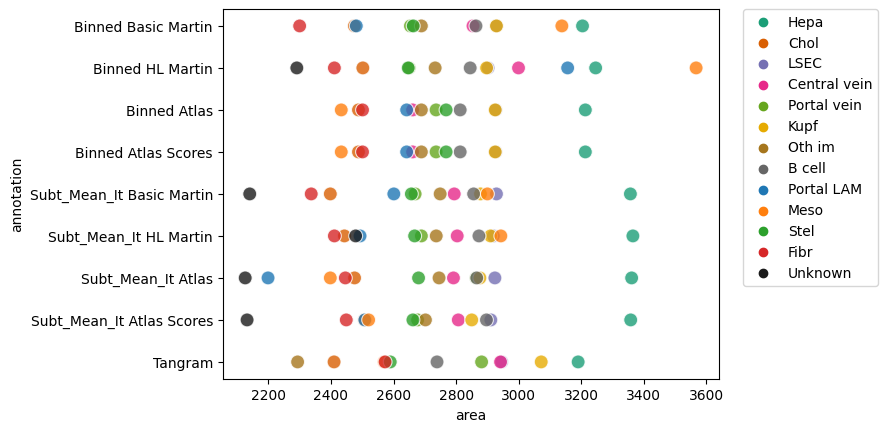

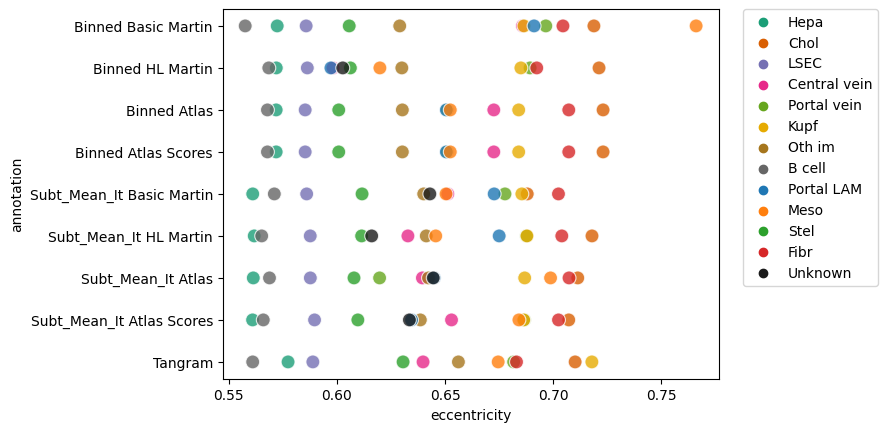

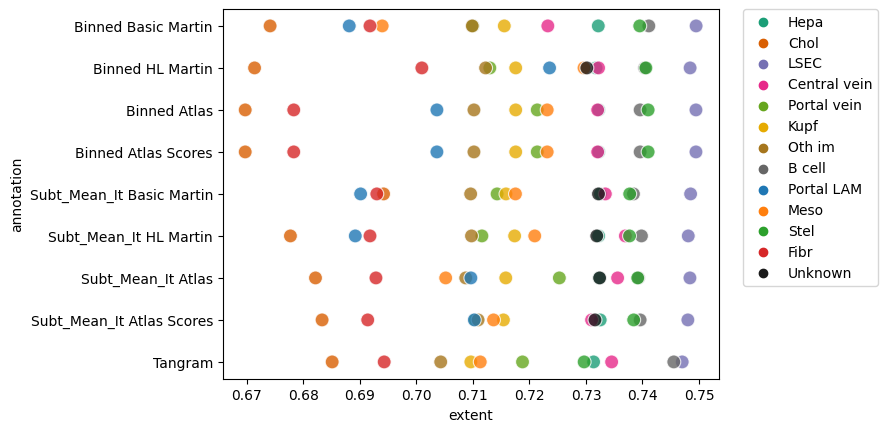

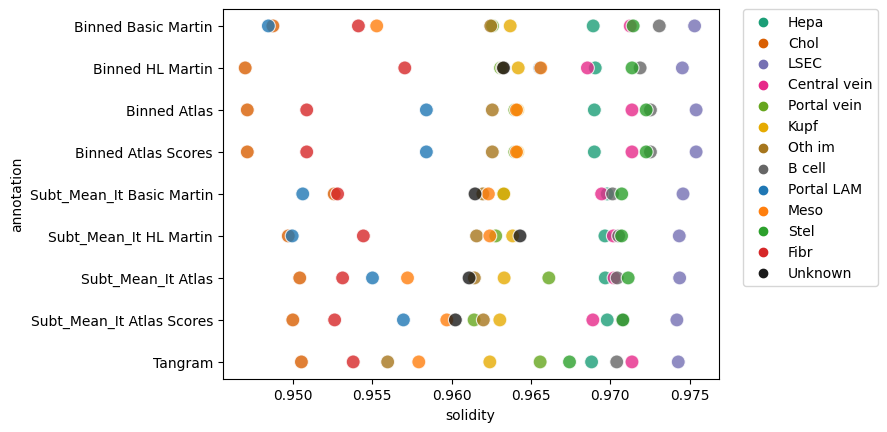

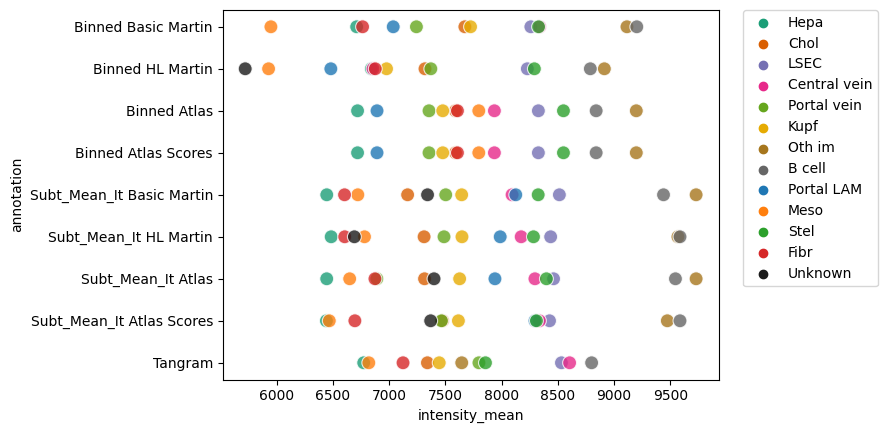

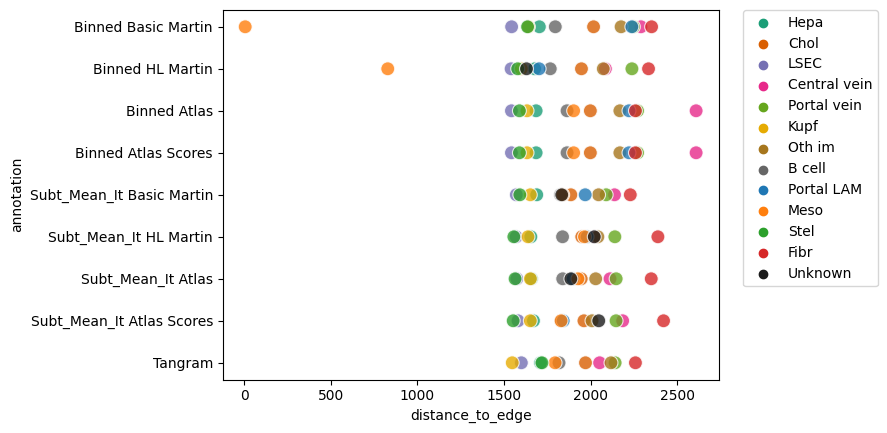

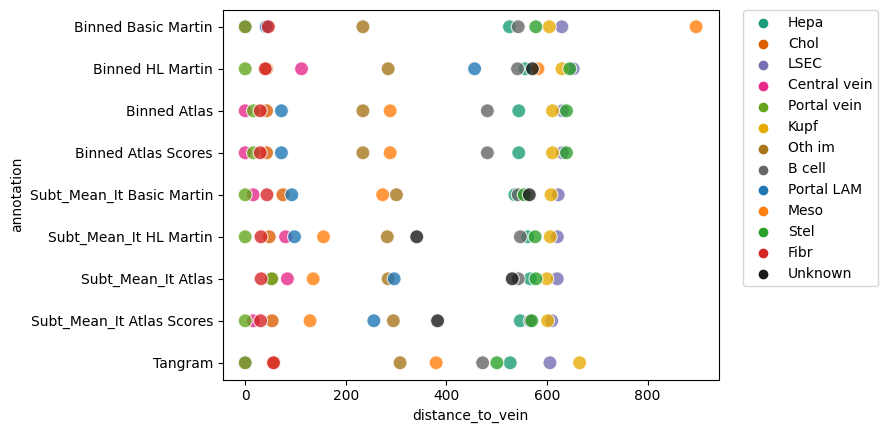

In [155]:
for feature in ['area', 'eccentricity', 'extent', 'solidity', 'intensity_mean', 'distance_to_edge', 'distance_to_vein']:
    sns.scatterplot(x=feature,y='annotation',hue='cell type',data=df_median,palette=palette,s=100,alpha=0.8)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

In [ ]:
score_name = 'own_score_genes_Atlas_Scores_12'
score_matrices = []
for i in range(len(anndata_objects)):
    score_matrices.append(anndata_objects[i].uns[score_name])
score_matrix_together = pd.concat(score_matrices)
# set smaller than 0 to NaN
score_matrix_together[score_matrix_together < 0] = np.nan


In [ ]:
score_matrix_together

In [ ]:
score_matrix_together_max = score_matrix_together.copy()
for i in range(score_matrix_together_max.shape[0]):
    max_value = score_matrix_together_max.iloc[i,:].max()
    score_matrix_together_max.iloc[i,score_matrix_together_max.iloc[i,:] < max_value] = np.nan

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(20,10))
sns.boxplot(data=score_matrix_together_max,ax=ax)
plt.xticks(rotation=90)
plt.title('Boxplot of winning scores per cell type')
plt.ylabel('score')
# add to each x label the percentage that is not NaN
for i in range(len(ax.get_xticklabels())):
    ax.text(i,-2,str(round(100*sum(score_matrix_together_max.iloc[:,i]>0)/len(score_matrix_together_max.iloc[:,i]),2))+'%',ha='center', fontsize=12)
plt.show()

In [ ]:
annotation = 'annotation_score_genes_original_Atlas_Scores_12'
cell_types = anndata_samples_together.obs[annotation].unique().tolist()  
# move 'Unknown' to last place
cell_types.remove('Unknown')
cell_types.append('Unknown')
# remove 'Hepa' from cell_types
cell_types_no_hepa = [x for x in cell_types if x != 'Hepa']
leiden_clusters_per_ct = clusteringVSleiden(anndata_samples_together,annotation,"leiden",cell_types=cell_types,print_results=True,cell_types_in_homog_plot=cell_types_no_hepa,homog_plot_only_hepa=True)

In [ ]:
anndata = anndata_samples_together
annotation = 'annotation_own_score_genes_Atlas_Scores_12'
sns.violinplot(data=anndata.obs,x="total_counts",y=annotation)
plt.show()
sns.violinplot(data=anndata.obs,x="shapeSize",y=annotation)
plt.show()
anndata.obs['count_density'] = anndata.obs['total_counts'] / anndata.obs['shapeSize']
sns.violinplot(data=anndata.obs,x="count_density",y=annotation)
plt.show()

In [ ]:
annotation = 'annotation_score_genes_original_Atlas_Scores_12'
path_mg = "/home/wout/Documents/Thesis_lokaal/Mouse_Liver_Resolve_Data/AtlasSecondLevelScores.csv"
name = 'Atlas Scores'
# drop first 11 characters
annotation_scores = annotation[11:]

In [ ]:
corr_matrices = []
for anndata in anndata_objects:
    scores = anndata.uns[annotation_scores]
    corr_matrix = scores.corr(method='pearson')
    corr_matrices.append(corr_matrix)   
# average df in corr_matrices
average_corr_matrix = sum(corr_matrices)/len(corr_matrices)
average_corr_matrix
# make heatmap
sns.heatmap(average_corr_matrix, annot=True,fmt='.2f',vmin=-1, vmax=1, cmap='coolwarm')
# add title
plt.title('Score correlation matrix '+name)

In [ ]:
Jacc_m = Jaccard_similarity_matrix(path_mg,name)

In [ ]:
# subtract matrices
diff_matrix = average_corr_matrix - Jacc_m
sns.heatmap(diff_matrix, annot=True,fmt='.2f',vmin=-1, vmax=1, cmap='coolwarm')
plt.title('Score correlation - Jaccard matrix '+name)